# Graphing: time vs. cases
This tutorial goes over how to use Seaborn to plot data accessed through our package. We will create a plot with "days since first case" on the x axis, and "number of confirmed cases" on the y axis, with different curves for different countries. We will include the countries with the 10 highest current infection counts.

In [1]:
import covid19pandas as cod

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime

First, we will find which 10 countries have the highest current infection counts.

In [2]:
data_type = "cases" # By using a variable, we can easily switch to plot a different data type
data = cod.get_data_jhu(data_type=data_type)

last_day = data["date"].max() # Get the last recorded day

current_ct = data[data['date'] == last_day] # Pull all records for that day
current_ct = current_ct[["Country/Region", data_type]] # Drop unnecessary columns
current_ct = current_ct.groupby("Country/Region").aggregate(np.sum)

top_ten_names = current_ct.sort_values(by=data_type).tail(10)
top_ten_names

These data were obtained from Johns Hopkins University (https://github.com/CSSEGISandData/COVID-19).


,cases
Country/Region,
Turkey,15679
Switzerland,17768
United Kingdom,29865
Iran,47593
France,57749
Germany,77872
China,82361
Spain,104118
Italy,110574


Now, we will select daily data for just those countries, and sum up counts for sub-regions within those countries.

In [3]:
top_ten_cts = data[data["Country/Region"].isin(top_ten_names.index)] # Filter out other countries
top_ten_cts = top_ten_cts[["date", "Country/Region", data_type]] # Get the columns we want
top_ten_cts = top_ten_cts.groupby(
    ["date", "Country/Region"]).aggregate(np.sum).reset_index() # Sum up total cases per day, per country

top_ten_cts.head(10)

,date,Country/Region,cases
0,2020-01-22,China,548
1,2020-01-22,US,1
2,2020-01-23,China,643
3,2020-01-23,US,1
4,2020-01-24,China,920
5,2020-01-24,France,2
6,2020-01-24,US,2
7,2020-01-25,China,1406
8,2020-01-25,France,3
9,2020-01-25,US,2


Now we need to replace the dates with the number of days since the 100th case in that country.

In [4]:
country_groups = top_ten_cts.groupby("Country/Region") # Create pandas GroupBy object on country

country_day_cts = pd.DataFrame(columns=["day", "Country/Region", data_type]) # We'll append everything to this
for country in top_ten_names.index:
    
    country_tbl = country_groups.get_group(country)
    country_tbl = country_tbl[country_tbl[data_type] >= 100] # Select only days with 100 or more cases
    assert(country_tbl["date"].duplicated().sum() == 0) # Verify there are no duplicate days
    
    day_number_col = range(0, len(country_tbl.index)) # Generate a column of day number since 100 cases
    country_tbl.insert(loc=0, column="day", value=day_number_col) # Insert the column
    country_tbl = country_tbl.drop(columns="date") # We don't need the date column anymore
    
    country_day_cts = pd.concat([country_day_cts, country_tbl]).sort_values(by="day")

country_day_cts = country_day_cts.apply(pd.to_numeric, errors="ignore")

country_day_cts.head(5)

,day,Country/Region,cases
431,0,Turkey,192
296,0,Switzerland,114
268,0,Spain,120
256,0,Germany,130
298,0,United Kingdom,116


In [5]:
country_day_cts.tail(5)

,day,Country/Region,cases
514,66,China,81999
524,67,China,82122
534,68,China,82198
544,69,China,82279
554,70,China,82361


We can now plot our data.

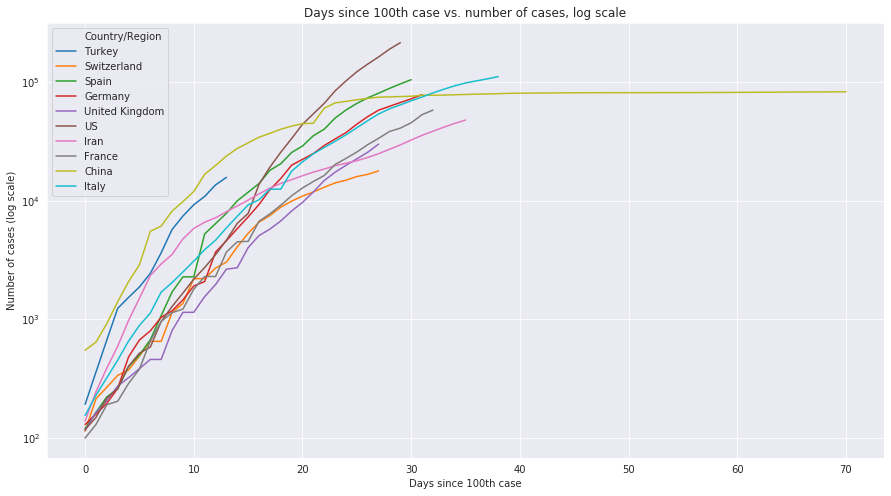

In [6]:
sns.set_style("darkgrid") # Set the plot colors
plt.figure(figsize=(15, 8)) # Set desired dimensions

ax = sns.lineplot(x="day", 
            y=data_type, 
            data=country_day_cts,
            hue="Country/Region")

ax.set(title="Days since 100th case vs. number of cases, log scale",
      xlabel="Days since 100th case",
      ylabel="Number of cases (log scale)",
      yscale="log")

plt.show()

We'll finish by creating a function that does all of that at once, and then plugging in different parameters.

In [7]:
def plot_days_vs_count(data_type="cases", min_count=100, num_countries=10, y_logscale=True):
    
    data = cod.get_data_jhu(data_type=data_type) # Get the data
    last_day = data["date"].max() # Get the last recorded day

    current_ct = data[data['date'] == last_day] # Pull all records for that day
    current_ct = current_ct[["Country/Region", data_type]] # Drop unnecessary columns
    current_ct = current_ct.groupby("Country/Region").aggregate(np.sum)

    top_names = current_ct.sort_values(by=data_type).tail(num_countries)
    top_cts = data[data["Country/Region"].isin(top_names.index)] # Filter out other countries
    top_cts = top_cts[["date", "Country/Region", data_type]] # Get the columns we want
    top_cts = top_cts.groupby(
        ["date", "Country/Region"]).aggregate(np.sum).reset_index() # Sum up total cases per day, per country

    country_groups = top_cts.groupby("Country/Region") # Create pandas GroupBy object on country

    country_day_cts = pd.DataFrame(columns=["day", "Country/Region", data_type]) # We'll append everything to this
    for country in top_names.index:

        country_tbl = country_groups.get_group(country)
        country_tbl = country_tbl[country_tbl[data_type] >= min_count] # Select only days with 100 or more cases
        assert(country_tbl["date"].duplicated().sum() == 0) # Verify there are no duplicate days

        day_number_col = range(0, len(country_tbl.index)) # Generate a column of day number since 100 cases
        country_tbl.insert(loc=0, column="day", value=day_number_col) # Insert the column
        country_tbl = country_tbl.drop(columns="date") # We don't need the date column anymore

        country_day_cts = pd.concat([country_day_cts, country_tbl]).sort_values(by="day")

    country_day_cts = country_day_cts.apply(pd.to_numeric, errors="ignore")
    country_day_cts

    sns.set_style("darkgrid") # Set the plot colors
    plt.figure(figsize=(15, 8)) # Set desired dimensions

    ax = sns.lineplot(x="day", 
                y=data_type, 
                data=country_day_cts,
                hue="Country/Region")

    if y_logscale:
        ax.set(title=f"Days since 100th case vs. number of {data_type}, log scale",
              xlabel="Days since 100th case",
              ylabel=f"Number of {data_type} (log scale)",
              yscale="log")
    else:
        ax.set(title=f"Days since 100th case vs. number of {data_type}, no log scale",
              xlabel="Days since 100th case",
              ylabel=f"Number of {data_type}")
        
    plt.show()

The graph looks pretty interesting if we don't have the y axis on a log scale:

These data were obtained from Johns Hopkins University (https://github.com/CSSEGISandData/COVID-19).


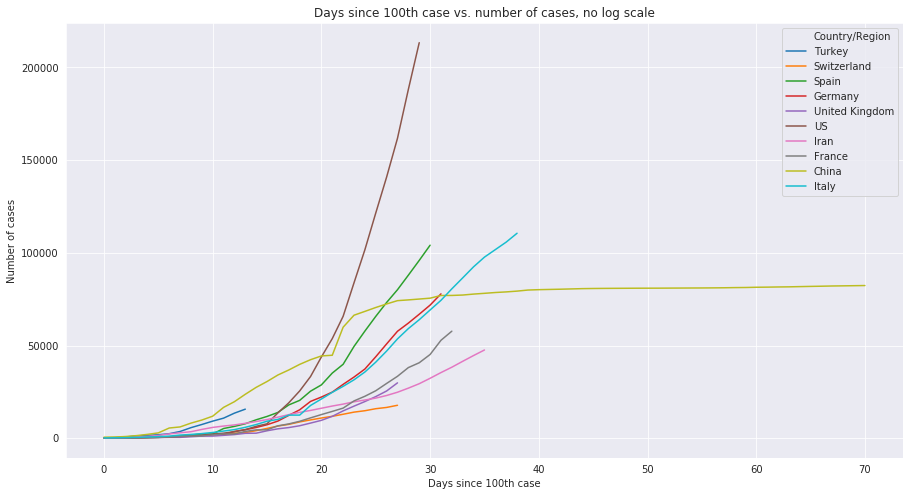

In [8]:
plot_days_vs_count(data_type="cases", min_count=100, num_countries=10, y_logscale=False)

Here are plots for deaths and recovered counts.

These data were obtained from Johns Hopkins University (https://github.com/CSSEGISandData/COVID-19).


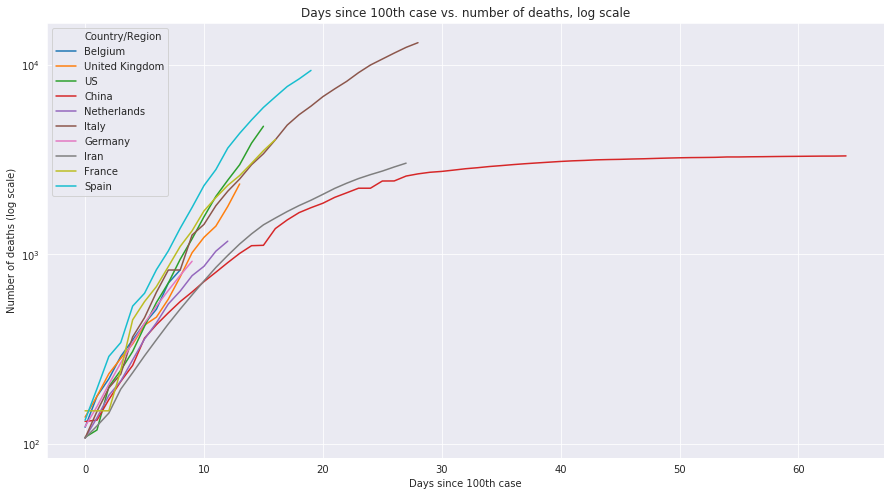

These data were obtained from Johns Hopkins University (https://github.com/CSSEGISandData/COVID-19).


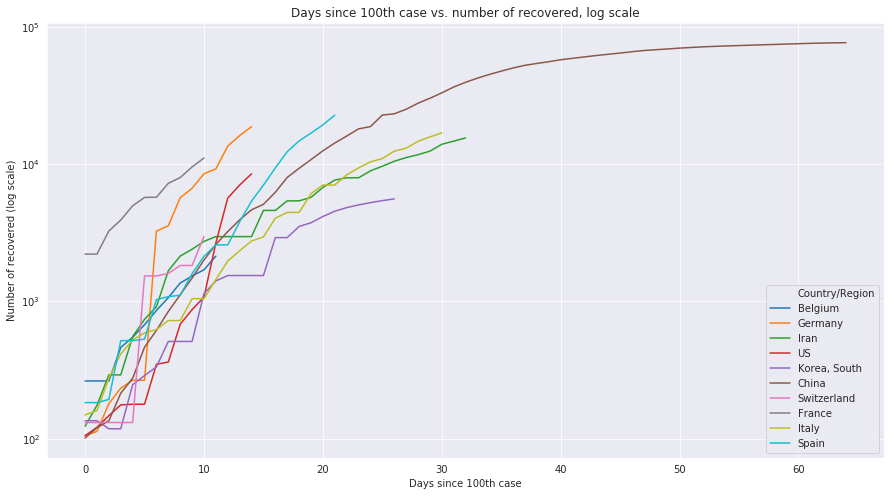

In [9]:
plot_days_vs_count(data_type="deaths", min_count=100, num_countries=10, y_logscale=True)
plot_days_vs_count(data_type="recovered", min_count=100, num_countries=10, y_logscale=True)